> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [TMDb movie data]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> This data set contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue.
Certain columns, like ‘cast’ and ‘genres’, contain multiple values separated by pipe (|) characters.
There are some odd characters in the ‘cast’ column. Don’t worry about cleaning them. You can leave them as is.
The final two columns ending with “_adj” show the budget and revenue of the associated movie in terms of 2010 dollars, accounting for inflation over time. 


### Questions for Analysis
>Movies have the highest revenues and lowest revenues.
Movies have the highest profit and highest loss.
Movies have the highest runtime and lowest runtime.

>Year to year what are the revenue, budget and profit/loss for all movies?


In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.
import pandas as pd
import numpy as np
import csv
from datetime import datetime
import matplotlib.pyplot as plt
% matplotlib inline

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html


In [2]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

Requirement already up-to-date: pandas==0.25.0 in /opt/conda/lib/python3.6/site-packages (0.25.0)


In [3]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.

#loading the csv file and storing it in the variable "tmbd_data"
df_tmdb = pd.read_csv('Database_TMDb_movie_data/tmdb-movies.csv')

<a id='wrangling'></a>
## Data Wrangling

> we'll keep only the relevent data that is going to be used in the analysis.**


### General Properties

In [4]:
#printing first five rows with defined columns of tmdb-movies database
df_tmdb.head(5)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


In [5]:
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1


### Data Cleaning
> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

In [6]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
# we need to remove every column that is not going to be used in the analysis.
delete_coloumn = ['id', 'imdb_id', 'popularity', 'budget_adj', 'revenue_adj', 'homepage', 'keywords', 'overview', 'production_companies', 'vote_count', 'vote_average']

#deleting the columns.
df_tmdb = df_tmdb.drop(delete_coloumn,1)

#checking after the dataset delete
df_tmdb.head(5)

,budget,revenue,original_title,cast,director,tagline,runtime,genres,release_date,release_year
0,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,The park is open.,124,Action|Adventure|Science Fiction|Thriller,6/9/15,2015
1,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,What a Lovely Day.,120,Action|Adventure|Science Fiction|Thriller,5/13/15,2015
2,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,One Choice Can Destroy You,119,Adventure|Science Fiction|Thriller,3/18/15,2015
3,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,Every generation has a story.,136,Action|Adventure|Science Fiction|Fantasy,12/15/15,2015
4,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,Vengeance Hits Home,137,Action|Crime|Thriller,4/1/15,2015


In [7]:
df_tmdb.shape

(10866, 10)

In [8]:
#we need to remove zeros from budget
df_tmdb = df_tmdb[df_tmdb['budget'] != 0]

#check the number of rows after removing the zeros from budget.
df_tmdb.shape

(5170, 10)

In [9]:
#we need to remove zeros from revenue.
df_tmdb = df_tmdb[df_tmdb['revenue'] != 0]

#check the number of rows after removing the zeros from revenue.
df_tmdb.shape

(3855, 10)

In [10]:
#we need to remove zero runtime since it might affect the analysis
df_tmdb = df_tmdb[df_tmdb['runtime'] != 0]

#check the number of rows after removing the zeros from revenue.
df_tmdb.shape

(3855, 10)

In [11]:
#we need to remove duplicates if any.
df_tmdb.drop_duplicates(keep = 'first', inplace = True)

#check the number of rows after removing duplicates.
df_tmdb.shape

(3854, 10)

In [12]:
df_tmdb.dropna(subset = ['runtime', 'revenue', 'budget'], inplace = True)

In [13]:
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3854 entries, 0 to 10848
Data columns (total 10 columns):
budget            3854 non-null int64
revenue           3854 non-null int64
original_title    3854 non-null object
cast              3850 non-null object
director          3853 non-null object
tagline           3574 non-null object
runtime           3854 non-null int64
genres            3854 non-null object
release_date      3854 non-null object
release_year      3854 non-null int64
dtypes: int64(4), object(6)
memory usage: 331.2+ KB


> now that we have a 3855 Movies and cleand the zeros we can start our analysis
<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. 



> **Tip**: - Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.




In [14]:
# create new column for profit column for every movies.
df_tmdb['profits'] = df_tmdb['revenue'] - df_tmdb['budget']

#check the data after adding the new column.
df_tmdb.head(5)

,budget,revenue,original_title,cast,director,tagline,runtime,genres,release_date,release_year,profits
0,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,The park is open.,124,Action|Adventure|Science Fiction|Thriller,6/9/15,2015,1363528810
1,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,What a Lovely Day.,120,Action|Adventure|Science Fiction|Thriller,5/13/15,2015,228436354
2,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,One Choice Can Destroy You,119,Adventure|Science Fiction|Thriller,3/18/15,2015,185238201
3,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,Every generation has a story.,136,Action|Adventure|Science Fiction|Fantasy,12/15/15,2015,1868178225
4,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,Vengeance Hits Home,137,Action|Crime|Thriller,4/1/15,2015,1316249360


In [15]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.
# to make the steps easier we could create a function to give the details of highest and lowest of column.
def highest_lowest(column):
    #for highest values.
    highest_details = df_tmdb[df_tmdb[column]==df_tmdb[column].max()]
    highest_details = highest_details.head(1)

    #for lowest values.
    lowest_details = df_tmdb[df_tmdb[column]==df_tmdb[column].min()]
    lowest_details = lowest_details.head(1)
    
    #merge them
    highest_lowest_details = pd.concat(([highest_details, lowest_details]))
    return highest_lowest_details.T

### Research Question 1 : Movies have the highest revenues and lowest revenues


In [16]:
#Use the function created earlier highest_lowst(column) to get the highest and lowest revenue.
highest_lowest('revenue')

,1386,5067
budget,237000000,6000000
revenue,2781505847,2
original_title,Avatar,Shattered Glass
cast,Sam Worthington|Zoe Saldana|Sigourney Weaver|S...,Hayden Christensen|Peter Sarsgaard|ChloÃ« Sevi...
director,James Cameron,Billy Ray
tagline,Enter the World of Pandora.,NaN
runtime,162,94
genres,Action|Adventure|Fantasy|Science Fiction,Drama|History
release_date,12/10/09,11/14/03
release_year,2009,2003


### Research Question 2: Movies have the highest profit and highest loss


In [17]:
#Use the function created earlier highest_lowst(column) to get the highest and lowest profits/loss.
highest_lowest('profits')

,1386,2244
budget,237000000,425000000
revenue,2781505847,11087569
original_title,Avatar,The Warrior's Way
cast,Sam Worthington|Zoe Saldana|Sigourney Weaver|S...,Kate Bosworth|Jang Dong-gun|Geoffrey Rush|Dann...
director,James Cameron,Sngmoo Lee
tagline,Enter the World of Pandora.,Assassin. Hero. Legend.
runtime,162,100
genres,Action|Adventure|Fantasy|Science Fiction,Adventure|Fantasy|Action|Western|Thriller
release_date,12/10/09,12/2/10
release_year,2009,2010


### Research Question 3: Movies have the highest and lowest budget


In [18]:
#Use the function created earlier highest_lowst(column) to get the highest and lowest budget.
highest_lowest('budget')

,2244,2618
budget,425000000,1
revenue,11087569,100
original_title,The Warrior's Way,Lost & Found
cast,Kate Bosworth|Jang Dong-gun|Geoffrey Rush|Dann...,David Spade|Sophie Marceau|Ever Carradine|Step...
director,Sngmoo Lee,Jeff Pollack
tagline,Assassin. Hero. Legend.,A comedy about a guy who would do anything to ...
runtime,100,95
genres,Adventure|Fantasy|Action|Western|Thriller,Comedy|Romance
release_date,12/2/10,4/23/99
release_year,2010,1999


### Research Question 4: Movies have the highest and lowest runtime


In [19]:
#Use the function created earlier highest_lowst(column) to get the highest and lowest runtime.
highest_lowest('runtime')

,2107,5162
budget,18000000,10
revenue,871279,5
original_title,Carlos,Kid's Story
cast,Edgar RamÃ­rez|Alexander Scheer|Fadi Abi Samra...,Clayton Watson|Keanu Reeves|Carrie-Anne Moss|K...
director,Olivier Assayas,Shinichiro Watanabe
tagline,The man who hijacked the world,NaN
runtime,338,15
genres,Crime|Drama|Thriller|History,Science Fiction|Animation
release_date,5/19/10,6/2/03
release_year,2010,2003


### Research Question 4: Year to year what are the revenue, budget and profit/loss for all movies?


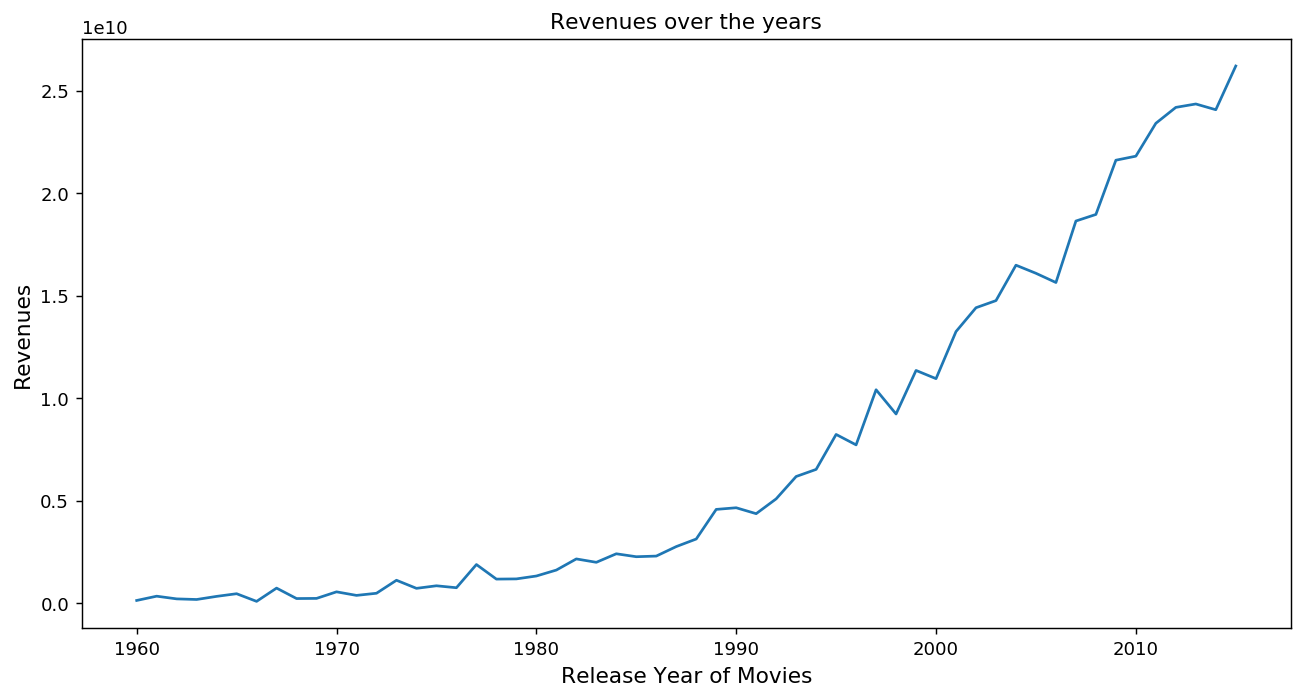

In [20]:
#to aggregate the revenues for each year.
revenues_year = df_tmdb.groupby('release_year')['revenue'].sum()

#for figure size
plt.figure(figsize=(12,6), dpi = 130)

#for X-Axis.
plt.xlabel('Release Year of Movies', fontsize = 12)

#for Y-Axis.
plt.ylabel('Revenues', fontsize = 12)

#for title
plt.title('Revenues over the years')

#for plotting the graph
plt.plot(revenues_year)

#for displaying the line chart
plt.show()

In [21]:
df_tmdb['revenue'].mean()

107686616.09807992

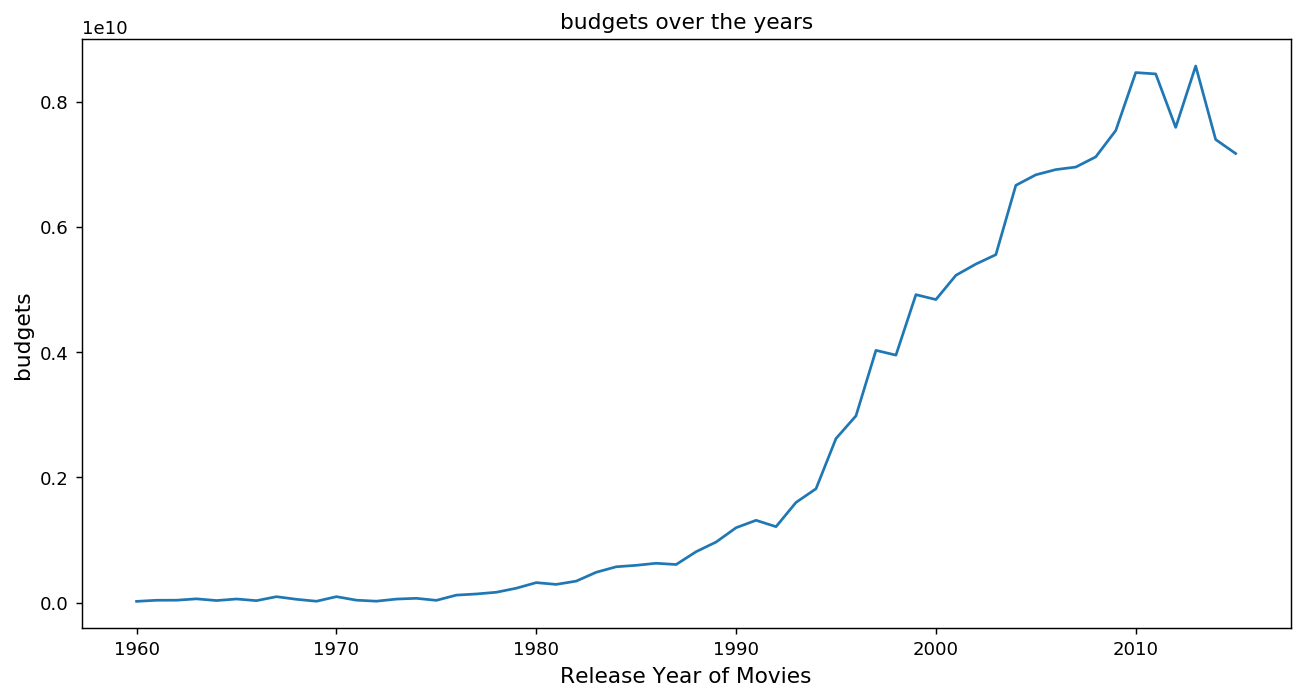

In [22]:
#to aggregate the budgets for each year.
budgets_year = df_tmdb.groupby('release_year')['budget'].sum()

#for figure size
plt.figure(figsize=(12,6), dpi = 130)

#for X-Axis.
plt.xlabel('Release Year of Movies', fontsize = 12)

#for Y-Axis.
plt.ylabel('budgets',fontsize = 12)

#for title
plt.title('budgets over the years')

#for plotting the graph
plt.plot(budgets_year)

#for displaying the line chart
plt.show()

In [23]:
df_tmdb['budget'].mean()

37203696.954852104

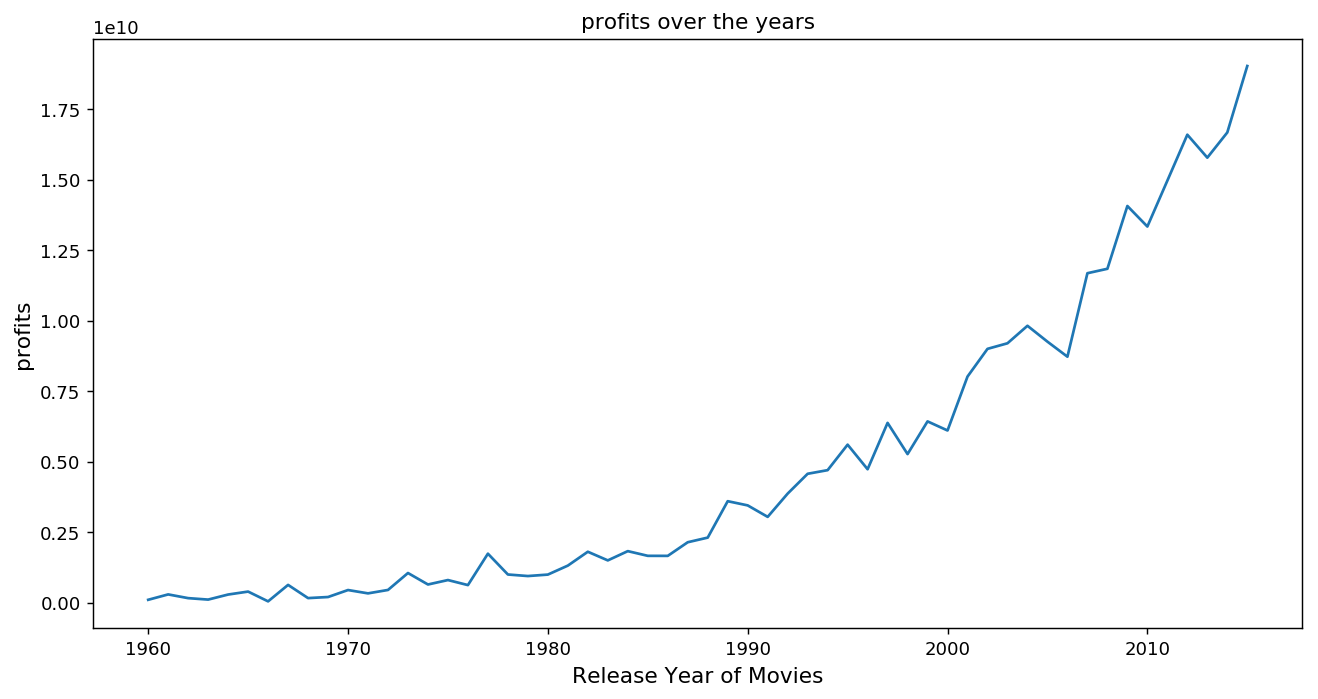

In [24]:
#to aggregate the profits for each year.
profits_year = df_tmdb.groupby('release_year')['profits'].sum()

#for figure size
plt.figure(figsize=(12,6), dpi = 130)

#for X-Axis.
plt.xlabel('Release Year of Movies', fontsize = 12)

#for Y-Axis.
plt.ylabel('profits', fontsize = 12)

#for title
plt.title('profits over the years')

#for plotting the graph
plt.plot(profits_year)

#for displaying the line chart
plt.show()

In [25]:
df_tmdb['profits'].mean()

70482919.14322782

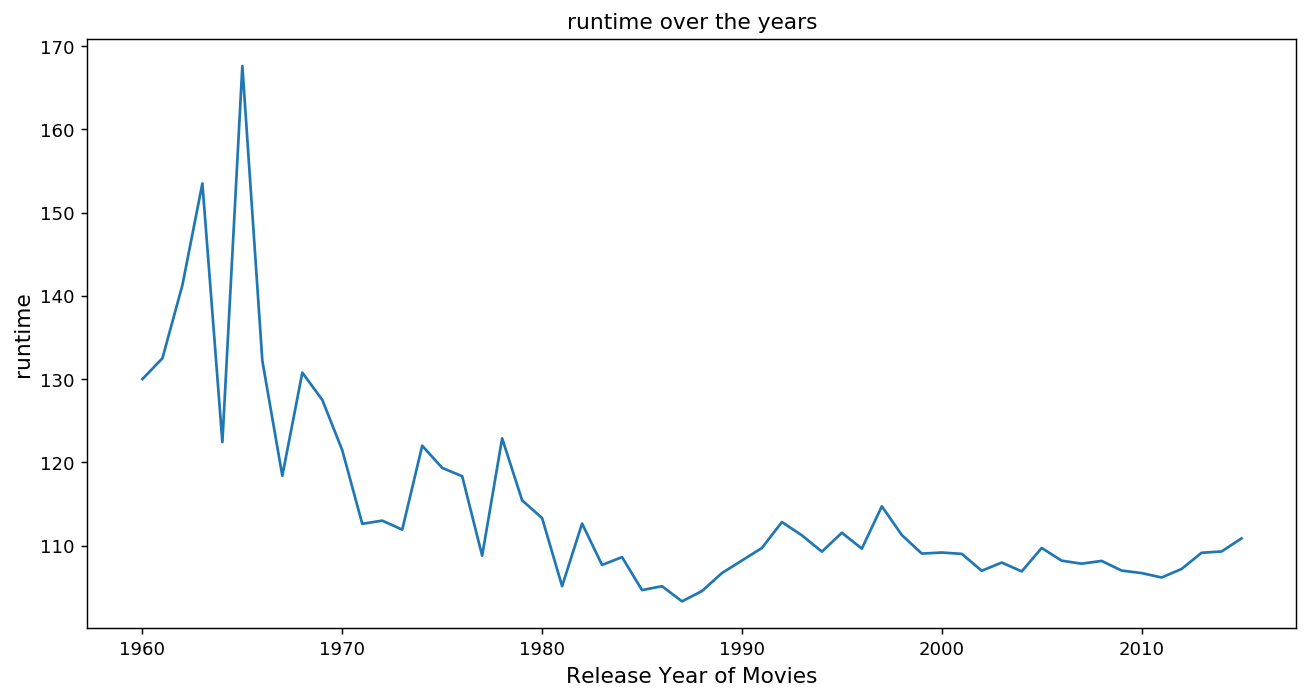

In [26]:
#to aggregate the profits for each year.
runtime_year = df_tmdb.groupby('release_year')['runtime'].mean()

#for figure size
plt.figure(figsize=(12,6), dpi = 130)

#for X-Axis.
plt.xlabel('Release Year of Movies', fontsize = 12)

#for Y-Axis.
plt.ylabel('runtime', fontsize = 12)

#for title
plt.title('runtime over the years')

#for plotting the graph
plt.plot(runtime_year)

#for displaying the line chart
plt.show()

In [27]:
df_tmdb['runtime'].mean()

109.22029060716139

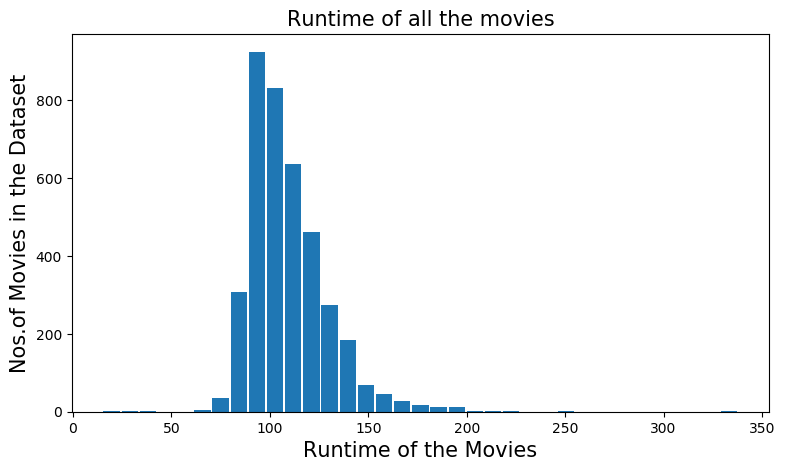

In [28]:
#plotting a histogram of runtime of movies
#figure size
plt.figure(figsize=(9,5), dpi = 100)

#For X-Axis 
plt.xlabel('Runtime of the Movies', fontsize = 15)

#For Y-Axis
plt.ylabel('Nos.of Movies in the Dataset', fontsize=15)

#Name of the graph
plt.title('Runtime of all the movies', fontsize=15)

#giving a histogram plot
plt.hist(df_tmdb['runtime'], rwidth = 0.9, bins =35)

#displays the plot
plt.show()

<a id='conclusions'></a>
## Conclusions

>The average run time has been decreasing over the year. The overall average of runtime is around 109 minutes.

>The revenues of movies has been increasing over the years. The average revenue is around 107 million.

>The budgets of the movies has been increasing over the years. The average budget is around 34 million.

>Although the budget has been increasing, the profits are increasing due to the fact the increase in revenues is much more the the increase of the budgets/costs in terms of values not a percentage. The average profits is around 70 million.

#### In Conclusion the movie buisness is thriving since it's getting to all time high in terms of revenues and profits.

#### Limitations: This analysis was done considering the movies which had a significant amount of profit of around 50 million dollar. This might not be completely error free but by following these suggestion one can increase the probability of a movie to become a hit. Moreover we are not sure if the data provided to us is completel corect and up-to-date. As mentioned before the budget and revenue column do not have currency unit, it might be possible different movies have budget in different currency according to the country they are produce in. So a disparity arises here which can state the complete analysis wrong. Dropping the rows with missing values also affected the overall analysis.

In [29]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0